### **Long Short Term Memory(LSTM)**,
a special type of Recurrent Neural Network(RNN) which can retain important information over time using memory cells.

This property of LSTMs makes it a wonderful algorithm to learn sequences that are interdependent and can help to build solutions like,
- language translation
- sales time series
- chatbots
- autocorrections
- next word suggestions, etc.

**Objective:** Using LSTM to learn the pattern in the stock prices, and predicting next days price of a stock based on the 10 days prices.

Library used: `yfinance`

Stock market ticker symbol: `INFY` for infosys

In [12]:
import pandas as pd
import numpy as np

# Remove scientific notations from numpy arrays
np.set_printoptions(suppress=True)

In [13]:
# installing nsepy library to get stock prices
!pip install yfinance


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import yfinance as yf

# Define the date range
start_date = "2023-03-09"
end_date = "2025-03-13"

#### Main components

- **Ticker**: single ticker data
- **Tickers**: multiple tickers' data
- **download**: download market data for multiple tickers
- **Market**: get infomation about a market
- **Search**: quotes and news from search
- **Sector and Industry**: sector and industry information
- **EquityQuery and Screener**: build query to screen market

A stock symbol or a ticker is a unique series of letters assigned to a security for trading purposes. For example:

1. For Amazon, it is “AMZN”
2. For Meta, it is “META”
3. For Google, it is “GOOGL”

In [15]:
# Fetching NIFTY 50 data from Yahoo Finance
StockData = yf.download("^NSEI", start=start_date, end=end_date)

# Reset the index to move 'Date' from index to a column
StockData = StockData.reset_index()

# Print the shape of the data and show the first few rows
print(StockData.shape)
print(StockData.head())

[*********************100%***********************]  1 of 1 completed

(495, 6)
Price        Date         Close          High           Low          Open  \
Ticker                    ^NSEI         ^NSEI         ^NSEI         ^NSEI   
0      2023-03-09  17589.599609  17772.349609  17573.599609  17772.050781   
1      2023-03-10  17412.900391  17451.500000  17324.349609  17443.800781   
2      2023-03-13  17154.300781  17529.900391  17113.449219  17421.900391   
3      2023-03-14  17043.300781  17224.650391  16987.099609  17160.550781   
4      2023-03-15  16972.150391  17211.349609  16938.900391  17166.449219   

Price   Volume  
Ticker   ^NSEI  
0       262400  
1       235900  
2       254900  
3       290600  
4       248200  


In [16]:
list(StockData.columns)

[('Date', ''),
 ('Close', '^NSEI'),
 ('High', '^NSEI'),
 ('Low', '^NSEI'),
 ('Open', '^NSEI'),
 ('Volume', '^NSEI')]

### Visualizing the stock prices movement

<Axes: xlabel='Date'>

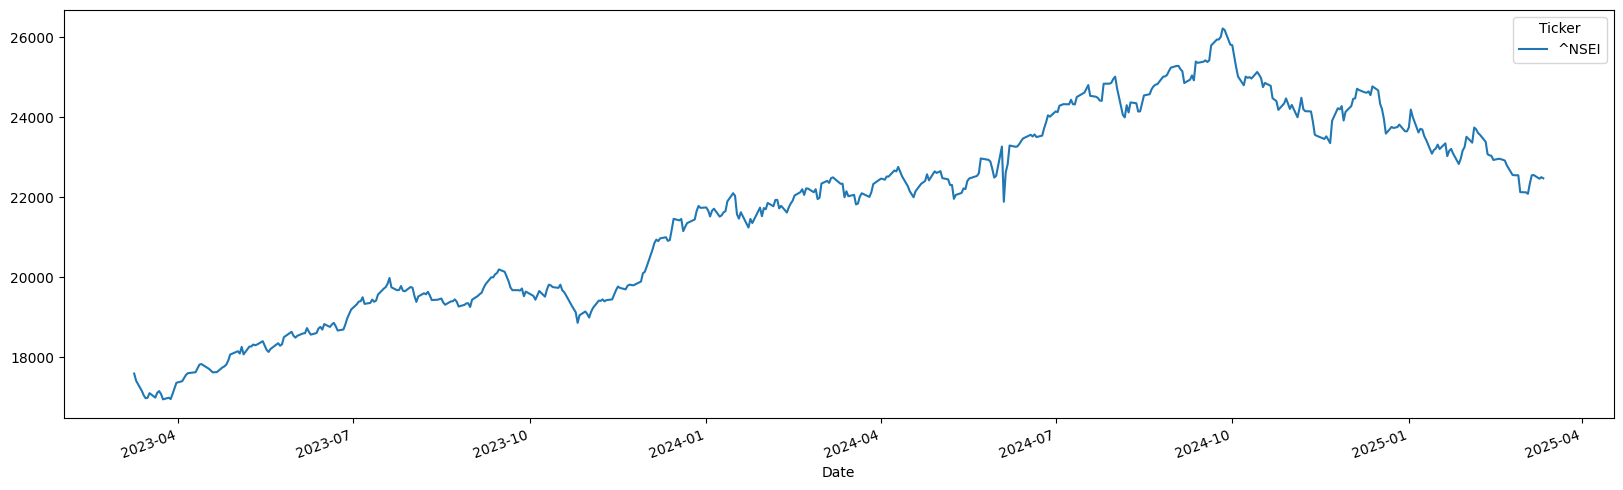

In [17]:
 # Plotting the stock prices
%matplotlib inline
StockData.plot(x='Date', y='Close', kind='line', figsize=(20,6), rot=20)

### Preparing the data

Giving data input into LSTM model in the form of X vs y, where,
- X : Represents the last 10 day's price
- y : Represents 11th day price

By looking at examples from last 2 years, LSTM would be able to learn the movement of price, thus after passing the last 10 days of price, it will be able to predict 11th days price.

Standardizing or normalizing the data is mandatory for a fast and more accurate fit as LSTM is a Neural network-based algorithm

In [18]:
# Extracting the closing prices of each day
FullData=StockData[['Close']].values
print(FullData[0:5])

[[17589.59960938]
 [17412.90039062]
 [17154.30078125]
 [17043.30078125]
 [16972.15039062]]


In [19]:
# Feature Scaling for fast training of the neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Choosing between Standardization or Normalization
# sc = StandardScaler()
sc=MinMaxScaler()

DataScaler=sc.fit(FullData)
X=DataScaler.transform(FullData)

print('### After Normalization ###')
X[0:5]

### After Normalization ###


array([[0.06952312],
       [0.05046377],
       [0.02257038],
       [0.01059756],
       [0.00292305]])

### Preparing the data for LSTM

In [20]:
# Split into samples
X_samples=list()
y_samples=list()

NumberOfRows=len(X)
# next day's Price Prediction is based on last 10 day's prices
TimeSteps=10

# Iterate through the values to create combinations
for i in range(TimeSteps, NumberOfRows, 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]

    X_samples.append(x_sample)
    y_samples.append(y_sample)

In [21]:
print(f"TimeSteps: {TimeSteps} \nNumberOfRows: {NumberOfRows}")

TimeSteps: 10 
NumberOfRows: 495


In [22]:
# Reshape the Input as a 3D (number of sample, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0], X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)

# Reshape the input as a 3D data as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n ### Output data shape ###')
print(y_data.shape)


#### Input Data shape ####
(485, 10, 1)

 ### Output data shape ###
(485, 1)


### Splitting the data into training and testing

In [23]:
# Keeping few days data for testing records
TestingRecords=5

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

In [24]:
# Printing the shape of training and testing
print('\n #### Training Data Shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n #### Testing Data Shape ####')
print(X_test.shape)
print(y_test.shape)



 #### Training Data Shape ####
(480, 10, 1)
(480, 1)

 #### Testing Data Shape ####
(5, 10, 1)
(5, 1)


### Visualizing the input and outpit data for LSTM

When input is 3D for the last 10 prices and output is 1D array of the next price.

In [25]:
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp, '-->', out)

[[0.06952312]
 [0.05046377]
 [0.02257038]
 [0.01059756]
 [0.00292305]
 [0.00437373]
 [0.0167188 ]
 [0.00467583]
 [0.0175223 ]
 [0.02231147]] --> [0.01422172]
[[0.05046377]
 [0.02257038]
 [0.01059756]
 [0.00292305]
 [0.00437373]
 [0.0167188 ]
 [0.00467583]
 [0.0175223 ]
 [0.02231147]
 [0.01422172]] --> [0.]


### Creating the DL LSTM model

- Using LSTM instead of Dense to define the hidden layers,
- The output has one neuron and we are predicting the next day price, for predicting for multiple days,
    - change input data and neurons equal to the number of days of forcast 

In [46]:
## Defining input shape for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps: ", TimeSteps)
print("NUmber of Features", TotalFeatures)

Number of TimeSteps:  10
NUmber of Features 1


In [51]:
print(f"Shape of X_train: {X_train.shape}")

Shape of X_train: (480, 10, 1)


Using 3 inputs and 1 output layer, we can increase or decrease number of neurons in each hiddent layers.

Also can increase and decrease the number of the output layer sneurons  in the hiddsn layer.

Hyperparamers of LSTM model,

- **units=10**:
- **input_shape=(TimeSteps, TotalFeatures)**
- **kernel_initializer = uniform**
-  **kernel_initialziser = 'uniform'**
-  **activation='relu'**
- **neuron_sequence s= True**
- **optimizer='adam'**
- **batch_size=10**
- **epochs=10**




In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [28]:
# Initializing the RNN
regressor=Sequential()

Adding the First input hidden layer and the LSTM layer and return_seqence = True,

- i.e. output of every time step to be shared with hidden next layer

In [29]:
regressor.add(LSTM(units=10, activation='relu', input_shape=(TimeSteps, TotalFeatures), return_sequences=True))

c:\Users\Dell\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Adding the Seconds Second hidden layer and the LSTM layer

In [30]:
regressor.add(LSTM(units=5, activation='relu', input_shape=(TimeSteps, TotalFeatures), return_sequences=True))

Adding the Seconds Third hidden layer and the LSTM layer

In [31]:
regressor.add(LSTM(units=5, activation='relu', return_sequences=True))

Adding the output layer

In [32]:
regressor.add(Dense(units=1))

Compiling the RNN

In [33]:
regressor.compile(optimizer='adam', loss='mean_squared_error')

Calculating the time for model to train

In [34]:
import time
# Measuing the tume taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size=5, epochs=10)

EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3057
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1181
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0583
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0471
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0364
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0303
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0261
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0201
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0188
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0163
## Total Time Taken:  0 Minutes ##


#### Measuring the accuracy of the model on testing data

Using the trained model data,

- Making predictions on the test data

In [56]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (480, 10, 1)
Shape of y_test: (5, 1)


In [74]:
predicted_Price=regressor.predict(X_test)

predicted_Price = predicted_Price.reshape(predicted_Price.shape[0], -1)

predicted_Price=DataScaler.inverse_transform(predicted_Price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [75]:
df1=np.array(predicted_Price)
df1.size

50

In [ ]:
# Getting the original price values for testing data
orig=y_test.reshape(y_test.shape[0],-1)